In [85]:
import numpy as np
from skimage.morphology import h_minima
from skimage.draw import ellipse
from scipy import ndimage as ndi

import load_satellite_data as lsd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

import fixed_colourbar as fc
import pandas as pd

In [41]:
def get_labeled_local_minima(field,minimum_depth=10):
    minima = h_minima(field,minimum_depth)
    
    return ndi.label(minima)[0]

def get_track_ellipses(field,elipsis_width=5,elipsis_height=9,elipsis_rotation=0):
    ellipses_field = np.zeros_like(field, dtype="uint8")
    
    # check if field is labeled, if not, label it
    if np.max(field) == 1:
        field = ndi.label(field)[0]
    
    for l in np.unique(field):
        min_loc = np.where(field == l)
    
        rr, cc = ellipse(min_loc[0][0],
                         min_loc[1][0],
                         elipsis_width, 
                         elipsis_height, 
                         rotation=elipsis_rotation)
        
        rr = np.clip(rr,0,field.shape[0]-1)
        cc = np.clip(cc,0,field.shape[1]-1)
        ellipses_field[rr,cc] = l
    
    ellipses_field = ~np.ma.masked_less(ellipses_field,1).mask*1
    return ellipses_field

def local_threshold(T, Tmax=273.15, thresh_min=240, Tmin=220, spread=5):
    T_thresh = np.max((T + spread, T + spread + 15*(T - Tmax)/ (Tmin - Tmax),thresh_min))
    return T_thresh

def mask_local_threshold(field,object_mask, Tmax=273.12, thresh_min = 240, Tmin = 220, spread = 5):
    tmin = np.min(field[object_mask])
    
    threshold = local_threshold( tmin, Tmax, thresh_min, Tmin, spread)

    threshold_mask = field < threshold
    threshold_mask_labeled = ndi.label(threshold_mask)[0]

    ll = threshold_mask_labeled[object_mask]
    ll = ll[ll>0]
    ll = ll[0]
    
    obj_location = np.where(object_mask*1 == 1)

    return (tmin, threshold,np.where(threshold_mask_labeled == ll))
    #return (tmin, threshold, obj_location)

In [3]:
test = lsd.load_satellite_data(dt.datetime(2013,6,18,12),"IR_108")

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
lml = get_labeled_local_minima(test,10)

In [5]:
np.unique(lml)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
ellipses = get_track_ellipses(lml)

In [60]:
objects = np.zeros((600,800),dtype="uint8")
lmins = np.zeros((600,800))
threshs = np.zeros((600,800))
obj = ndi.label(ellipses)[0]

In [62]:
for l in np.unique(obj)[1:]:
    omask = np.ma.masked_equal(obj,l).mask
    
    tmin, thresh, obj_loc = mask_local_threshold(test,omask)
    
    objects[obj_loc] = l
    lmins[obj_loc] = tmin
    threshs[obj_loc] = thresh

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220


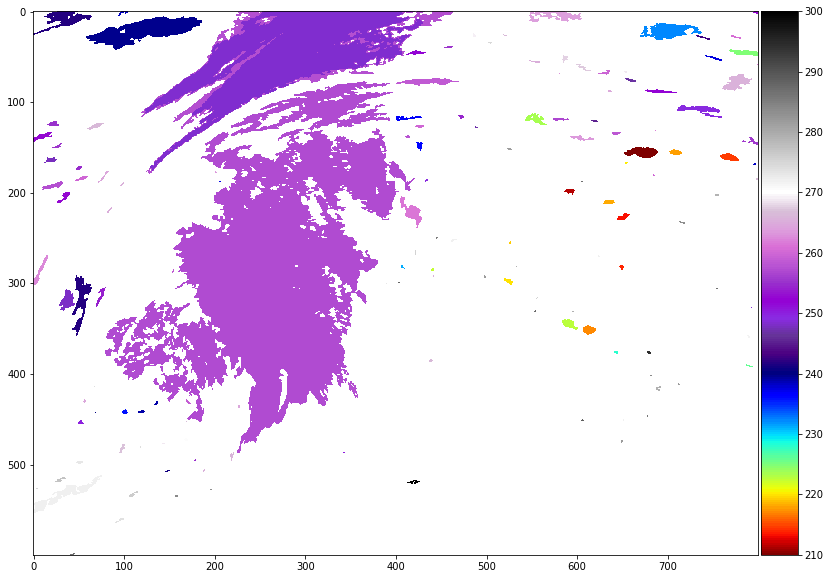

In [74]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
p = ax.imshow(np.ma.masked_where(objects<1,lmins),vmin=210,vmax=300,cmap=emap)
fc.colourbar(p)

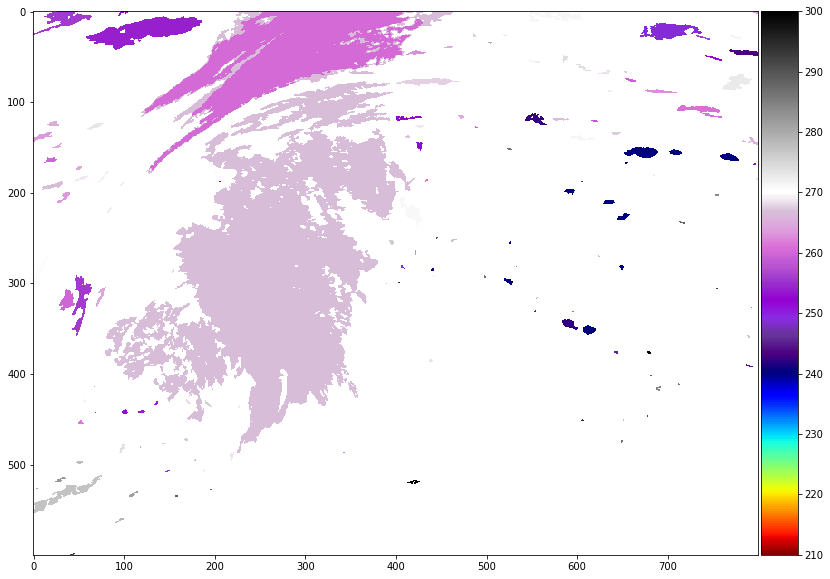

In [75]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
p = ax.imshow(np.ma.masked_where(objects<1,threshs),vmin=210,vmax=300,cmap=emap)
fc.colourbar(p)

In [77]:
times = pd.date_range(start="20130618T1100",end="20130618T1200",freq="5min")

In [78]:
sat_data = np.array([lsd.load_satellite_data(t.to_pydatetime(),"IR_108") for t in times])

Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


In [113]:
locmin = np.zeros_like(sat_data,dtype="uint8")
ellipses = np.zeros_like(sat_data, dtype="uint8")

In [114]:
for i,sd in enumerate(sat_data):
    lm = get_labeled_local_minima(sd,10)
    e = get_track_ellipses(lm)
    
    locmin[i,:,:] = lm
    ellipses[i,:,:] = e

In [115]:
objects = np.zeros_like(sat_data,dtype="uint8")
lmins = np.zeros_like(sat_data)
threshs = np.zeros_like(sat_data)
obj = ndi.label(ellipses)[0]

In [116]:
for i in range(len(obj)):
    for l in np.unique(obj[i])[1:]:
        omask = np.ma.masked_equal(obj[i],l).mask

        tmin, thresh, obj_loc = mask_local_threshold(sat_data[i],omask)

        objects[i][obj_loc] = l
        lmins[i][obj_loc] = tmin
        threshs[i][obj_loc] = thresh

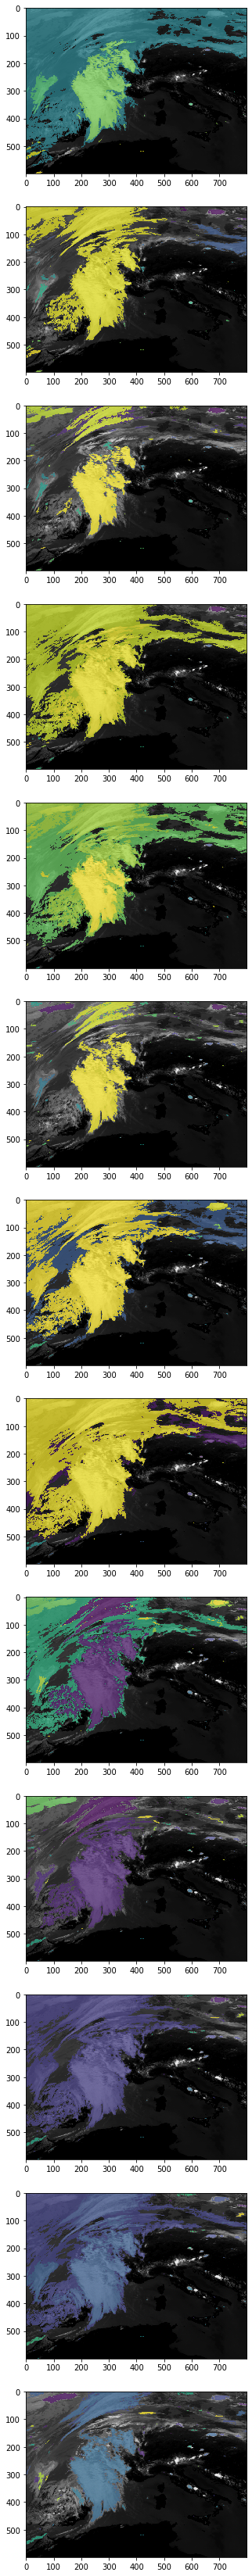

In [137]:
fig,ax = plt.subplots(13,1,figsize=(8,60))
for i,o in enumerate(objects):
    ax[i].imshow(sat_data[i],vmin=210,vmax=300, cmap='gray_r')
    ax[i].imshow(np.ma.masked_less(o,1),alpha=0.7)

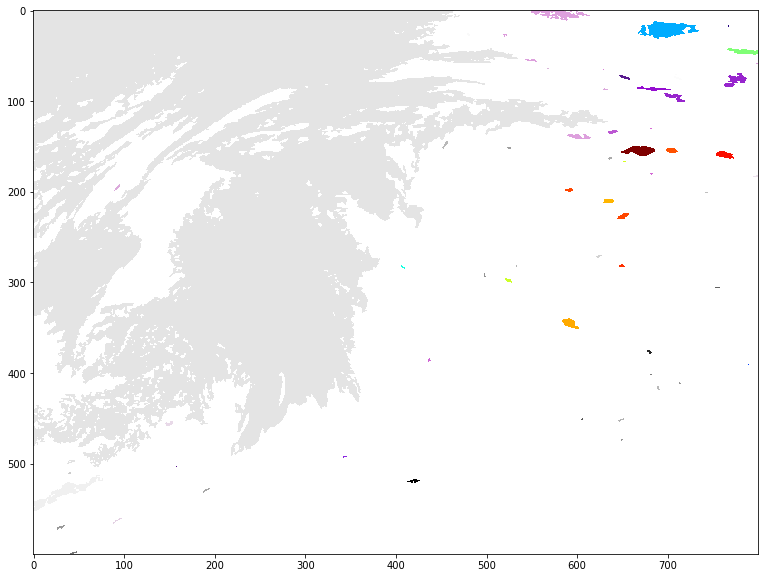

In [152]:
i = 10
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.ma.masked_where(objects[i]<1,lmins[i]),vmin=210,vmax=300, cmap=emap)

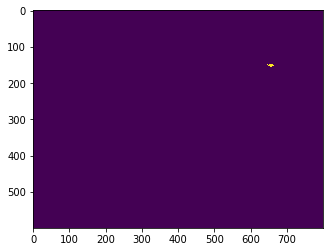

In [173]:
plt.imshow(objects[0] == 50)

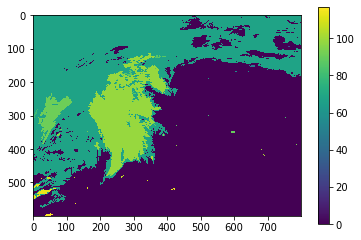

In [168]:
plt.imshow(objects[0])
plt.colorbar()

In [159]:
np.unique(objects[0])

array([  0,  29,  50,  53,  54,  57,  58,  59,  62,  63,  64,  66,  67,
        68,  69,  70,  76,  77,  79,  80,  82,  83,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117], dtype=uint8)